### Gradient Boosting and XGBoost

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_auc_score, f1_score

from sklearn.metrics import roc_auc_score
from pylab import rcParams

import seaborn as sns

In [2]:
rcParams['figure.figsize'] = 13, 8
sns.set()

In [37]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [38]:
def evaluate_score(score):
    mean = np.mean(score)
    std = np.std(score)
    print(f"Average score:{mean}+/-{std}%")
    plt.boxplot(scores)
    plt.ylabel("Accuracy")

### Problem Formulation
For this method we will frame the anomaly detection problem as a supervised learning problem.
We have been provided with one dataset of normal data, and three datasets of abnormal data corresponding to different failing substations, so we label our data accordingly.

Our dataset is spread over many csv files. We keep only the voltage series, add a label column and concatanate all dataframes into one.
So now we have one dataset which rows are sampled sequences and the last column is the label of this sequence. The other columns,or features are the voltage measuremets taken at equal time intervals.
Now we can train a classifier to tell apart the normal from the problematic sequences.

In [39]:
df_normal_list = pd.DataFrame()
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t')
    df = df[['voltage [V]']][:1000].transpose()
    #df = df.set_index("loc. (actual) [km]")
    # df.dropna(inplace=True)
    # df.sort_index(inplace=True)
    if df_normal_list.empty:
        df_normal_list = df
    else:
        df_normal_list = df_normal_list.append(df)
    df_normal_list['label'] = np.zeros((len(df_normal_list), 1)).astype(int)

In [40]:
df_error = pd.DataFrame()
for i in range(1, 4):
    df_error_list = pd.DataFrame()
    pathlist = Path(f"/home/aggelos-i3/Downloads/simu Elbas/7h33D{i}").glob(
        '**/*.xls')
    for path in pathlist:
        # because path is object not string
        path_in_str = str(path)
        df = pd.read_csv(path_in_str, delimiter='\t')
        df = df[['voltage [V]']][:1000].transpose()
        #df = df.set_index("loc. (actual) [km]")
        # df.dropna(inplace=True)
        if df_error_list.empty:
            df_error_list = df
        else:
            df_error_list = df_error_list.append(df)
    df_error_list['label'] = np.full((len(df_error_list), 1), i)
    if df_error.empty:
        df_error = df_error_list
    else:
        df_error = df_error.append(df_error_list)

In [41]:
dataset = pd.concat([df_normal_list, df_error], axis=0)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,label
voltage [V],786.405701,786.639587,786.379334,784.256592,780.714844,778.763306,782.088318,783.523987,780.188293,777.495178,...,786.784668,768.494263,784.005981,783.392395,789.532166,807.949036,814.559753,800.102783,796.938782,0
voltage [V],779.298523,784.582092,784.545837,786.837707,786.543274,798.836426,790.527100,789.838745,789.973694,799.427368,...,811.612183,791.882263,789.414612,788.484009,789.817444,787.505310,786.985413,786.065735,785.140198,0
voltage [V],787.283691,787.139526,787.761169,785.451965,781.759216,780.349670,782.838196,784.542236,781.135864,777.579956,...,784.960266,771.365295,784.200134,784.396606,787.995178,789.061951,793.676819,790.727234,789.559631,0
voltage [V],787.833374,785.052185,783.197754,782.131409,782.864990,785.359985,784.958130,784.552978,784.945129,785.139221,...,802.239014,791.855164,792.489319,788.695557,786.465271,780.335022,782.420410,784.481934,786.711731,0
voltage [V],784.085999,780.306274,779.111633,781.541016,781.815063,781.669922,777.798889,785.667725,787.680664,812.313232,...,845.801819,833.462219,800.511536,798.087158,791.580994,787.848816,787.086548,785.023132,782.941528,0


In [42]:
# we shuffle our dataset
class_names = np.array(['Normal', 'D1 Error', 'D2 error', 'D3 error'])

dataset = shuffle(dataset)
dataset.dropna(inplace=True)
#dataset.describe()

We will use kfold cross validation to optimize the number of estimators our algorithm is using.

In [52]:
scaler = StandardScaler()
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dcvset = xgb.DMatrix(X, y)
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4
}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

model = xgb.XGBClassifier(objective='multi:softprob')

# do cross validation
#print('Start cross validation')
cvresult = xgb.cv(param,
                  dcvset,
                  num_boost_round=5000,
                  nfold=15,
                  metrics=['mlogloss'],
                  early_stopping_rounds=50,
                  stratified=True,
                  as_pandas=True,
                  seed=1301)
print(cvresult.head())

   train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0             0.948132            0.005641            1.117152   
1             0.682062            0.005156            0.936179   
2             0.504141            0.004608            0.819749   
3             0.381874            0.004137            0.732228   
4             0.293869            0.004243            0.669964   

   test-mlogloss-std  
0           0.084682  
1           0.130132  
2           0.150314  
3           0.163259  
4           0.173462  


Text(0, 0.5, 'Log Loss')

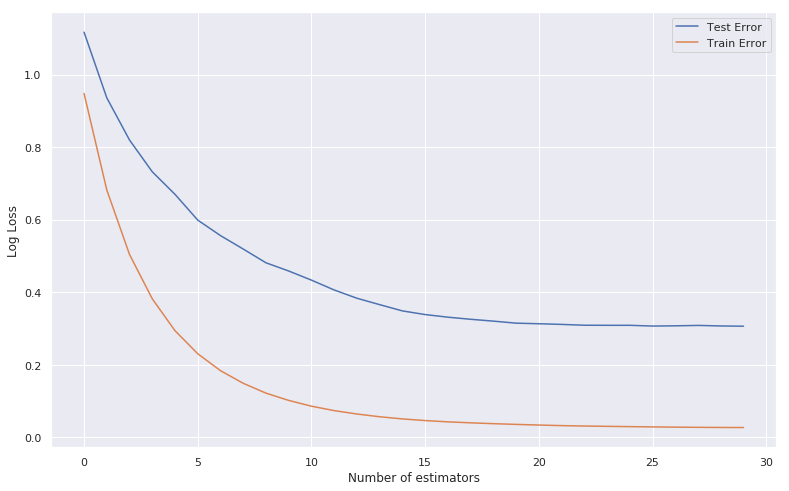

In [61]:
plt.plot(cvresult['test-mlogloss-mean'], label='Test Error')
plt.plot(cvresult['train-mlogloss-mean'], label='Train Error')
plt.legend(loc='best')
plt.xlabel("Number of estimators")
plt.ylabel("Log Loss")

In [44]:
model.set_params(n_estimators=cvresult.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
print('Best number of trees = {}'.format(cvresult.shape[0]))

Best number of trees = 30


We split our data in a train and a test set to perform an example:

In [46]:
print("Example prediction")
print('Fit on the training data')
model.fit(X_train, y_train)
print('Predict the probabilities based on features in the test set')
pred = model.predict(X_test, ntree_limit=cvresult.shape[0])
print("Example Predictions: ", pred)
print("True Labels:         ", y_test)
print("Accuracy: ", accuracy_score(pred, y_test) * 100, "%")

Example prediction
Fit on the training data
Predict the probabilities based on features in the test set
Example Predictions:  [0 2 1 2 1 0 1 0 3 3 3 2 0 3 1 3 0 1 1 0]
True Labels:          [3 3 1 2 1 0 1 3 3 3 3 2 0 3 2 3 0 2 1 0]
Accuracy:  75.0 %


We can visualize the importance of each feature for our trained model.
We see that the most important features for the model, which are the ones most responsible for the prediction, are the near the substations.

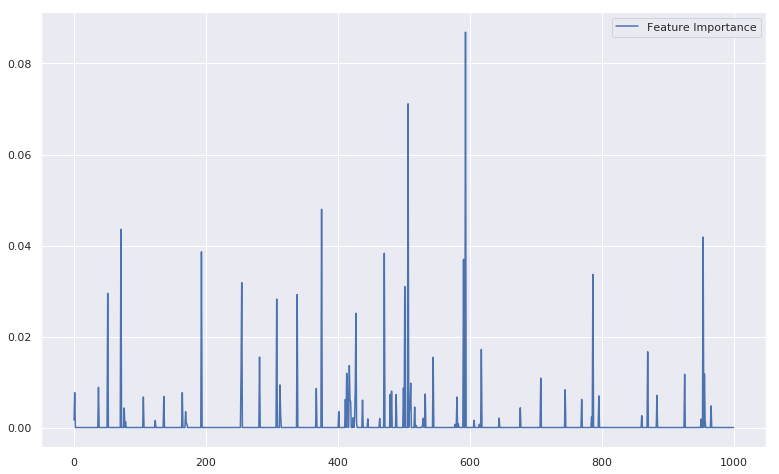

In [47]:
plt.plot(np.arange(len(model.feature_importances_)),
         model.feature_importances_,
         label='Feature Importance')
plt.legend(loc='best')

In order to measure the perfomance of our model more reliably we perform a stratified kfold cross validation over 15 folds.
Below we present our results in a boxplot demonstrating the accuracy of our algorithm and a confusion matrix to better interpretate those results.

Average score:0.9416666666666667+/-0.08975274678557507%


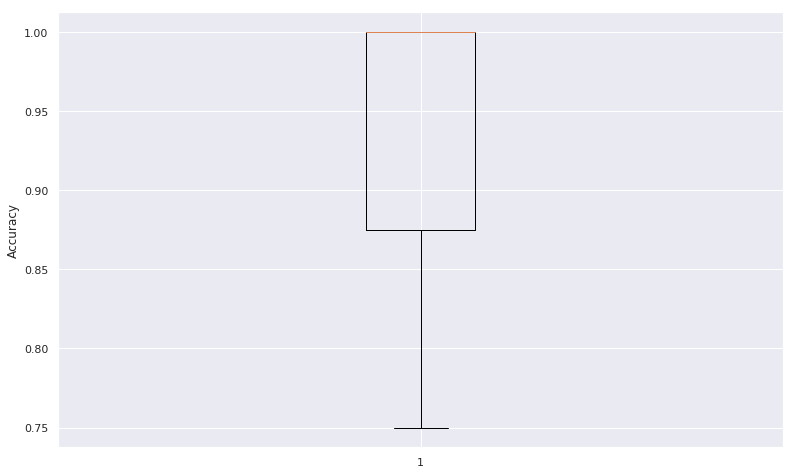

In [48]:
# Kfold
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=15)
scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)
evaluate_score(scores)

In [49]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, X, y, cv=10)
#conf_mat = confusion_matrix(y, y_pred)

Normalized confusion matrix
[[0.85 0.   0.   0.15]
 [0.   0.9  0.1  0.  ]
 [0.   0.1  0.85 0.05]
 [0.05 0.   0.05 0.9 ]]


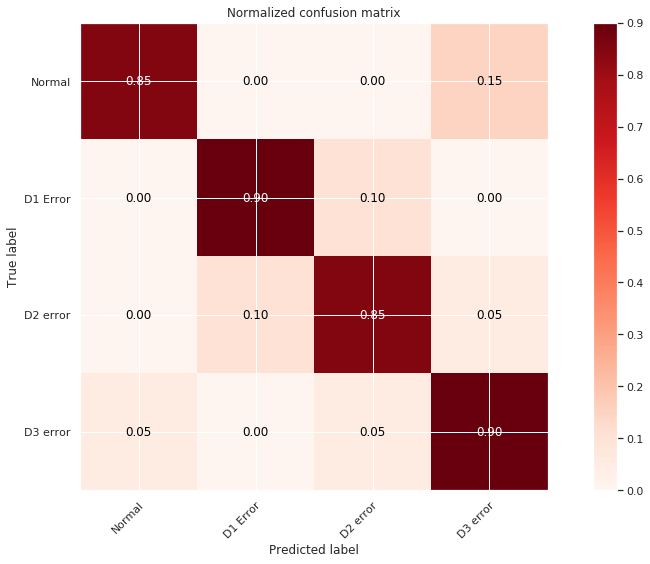

In [50]:
plot_confusion_matrix(y,
                      y_pred,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')

Confusion matrix, without normalization
[[17  0  0  3]
 [ 0 18  2  0]
 [ 0  2 17  1]
 [ 1  0  1 18]]


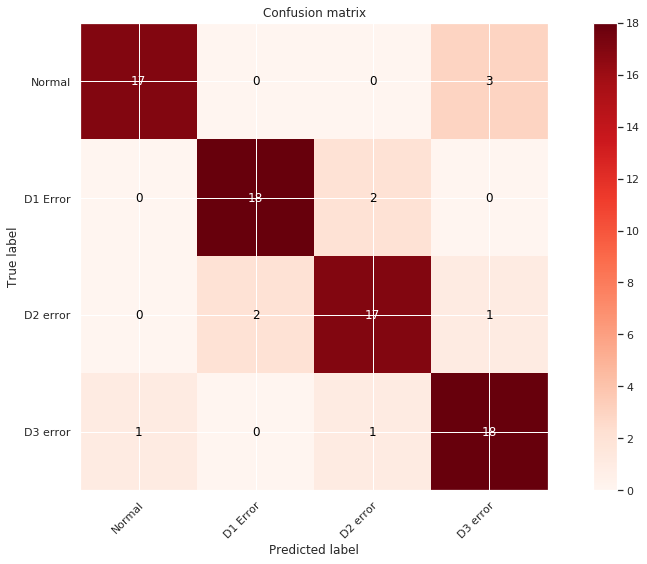

In [51]:
plot_confusion_matrix(y,
                      y_pred,
                      classes=class_names,
                      normalize=False,
                      title='Confusion matrix')